In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from numpy.random import seed
from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data_files = glob.glob("../Tell1CalibCsv/*.csv")

In [3]:
def module_names():
    names = []
    data = pd.read_csv(data_files[0] ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    names = data[1]
    return names

In [4]:
map_data_path = "../module_mapping.csv"
map_data = pd.read_csv(map_data_path ,sep=' ', engine='python', index_col=False)
map_data_R = map_data[map_data["sensor_type"] == "R"].sort_values(by=['sensor_number'])
map_data_Phi = map_data[map_data["sensor_type"] == "phi"].sort_values(by=['sensor_number'])

r_sensors_numbers = map_data_R["sensor_number"][0:42].tolist()
phi_sensors_numbers = map_data_Phi["sensor_number"].tolist()

r_sensors_names = []
for i in r_sensors_numbers:
    r_sensors_names.append("VeloTELL1Board" + str(i))

phi_sensors_names = []
for i in phi_sensors_numbers:
    phi_sensors_names.append("VeloTELL1Board" + str(i))

In [5]:
def plot_history(train_loss):
    plt.figure(figsize=(15, 5))
#    ax = plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title("Train loss")
#    ax = plt.subplot(1, 2, 2)
#    plt.plot(history.history["val_loss"])
#    plt.title("Test loss")

In [5]:
ncol   = 84
inputS = (ncol,)
modelRelu  = Sequential()

# Encoder Layers
modelRelu.add(Dense(40, activation = 'relu', input_shape=inputS))
modelRelu.add(Dense(10, activation = 'relu'))
modelRelu.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelRelu.add(Dense(10, activation = 'relu'))
modelRelu.add(Dense(40, activation = 'relu'))
modelRelu.add(Dense(84, activation = 'sigmoid'))

# Compile the Model
modelRelu.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelRelu.summary()

W0630 00:29:50.102396  2416 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 00:29:50.132378  2416 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 00:29:50.136377  2416 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 00:29:50.275288  2416 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 00:29:50.286281  2416 deprecation_wrapper.py:119] From c:\program file

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_5 (Dense)              (None, 84)                3444      
Total params: 7,746
Trainable params: 7,746
Non-trainable params: 0
_________________________________________________________________


W0630 00:29:52.103154  2416 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



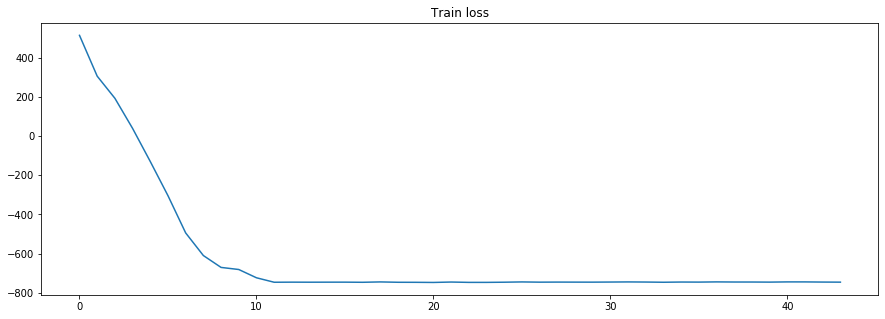

In [6]:
train_loss_fit = []
train_loss_batch = []
for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_train = data2.T
    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelRelu.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [7]:
chanell_encoder = Model(modelRelu.input, modelRelu.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 84)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
Total params: 3,832
Trainable params: 3,832
Non-trainable params: 0
_________________________________________________________________


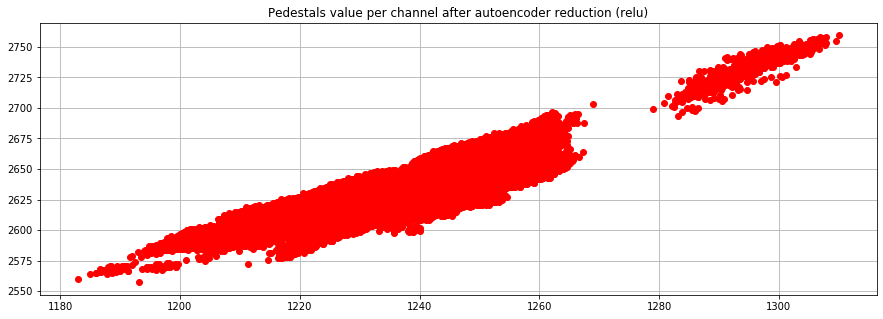

In [9]:
fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu)')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

W0710 00:47:26.329384  7920 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 00:47:26.418331  7920 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 00:47:26.544252  7920 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 00:47:26.545251  7920 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 00:47:26.547250  7920 deprecation_wrapper.py:119] From c:

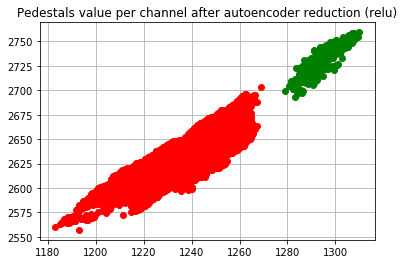

In [6]:
chanell_encoderS = load_model('relu_channel_model2.h5')

fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu)')

sensor_numbers_GG = []
sensor_numbers_RR = []

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    for i in data_test.index:
        if Zenc[i,0] > 1270:
            ax.plot(Zenc[i,0], Zenc[i,1], 'go')
            sensor_numbers_GG.append(i)
        else:
            ax.plot(Zenc[i,0], Zenc[i,1], 'ro')
            sensor_numbers_RR.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [7]:
print("[channel number, amount]")
for x in set(sensor_numbers_GG):
    print("[{:>14}, {:>6}]".format(x, sensor_numbers_GG.count(x)))

[channel number, amount]
[          1792,     44]
[          1793,     44]
[          1794,     44]
[          1795,     44]
[          1796,     44]
[          1797,     44]
[          1798,     44]
[          1799,     44]
[          1800,     44]
[          1801,     44]
[          1802,     44]
[          1803,     44]
[          1804,     44]
[          1805,     44]
[          1806,     44]
[          1807,     44]
[          1808,     44]
[          1809,     44]
[          1810,     44]
[          1811,     44]
[          1812,     44]
[          1813,     44]
[          1814,     44]
[          1815,     44]
[          1816,     44]
[          1817,     44]
[          1818,     44]
[          1819,     44]
[          1820,     44]
[          1821,     44]
[          1822,     44]
[          1823,     44]


In [8]:
snR = [[x,sensor_numbers_RR.count(x)] for x in set(sensor_numbers_RR)]
snG = [[x,sensor_numbers_GG.count(x)] for x in set(sensor_numbers_GG)]

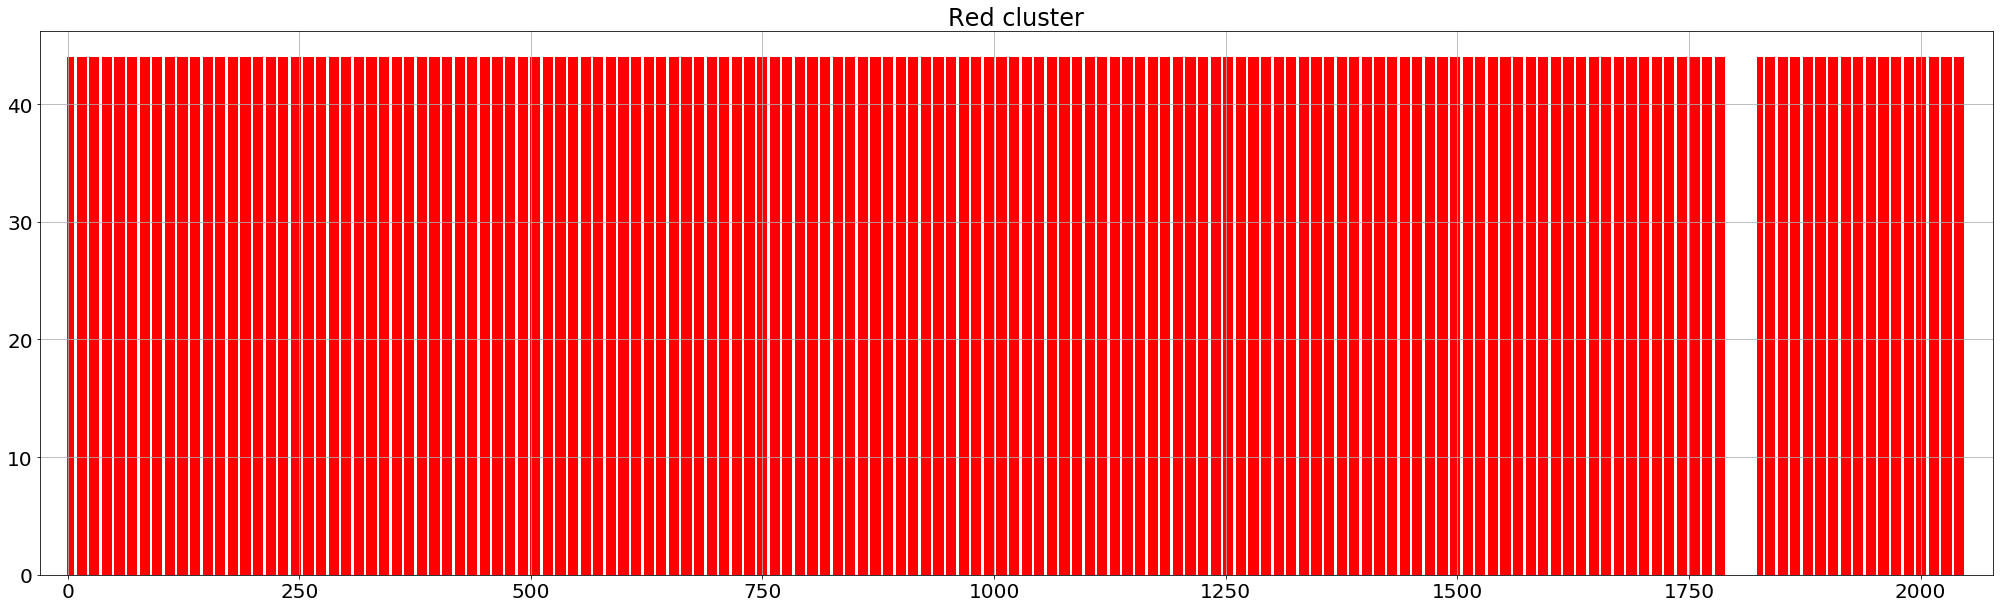

In [9]:
barData = pd.DataFrame.from_records(snR)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Red cluster')  
ax.bar(barData[0], barData[1], color='r')
ax.set_xlim([-30, 2078])
ax.grid()

plt.show()

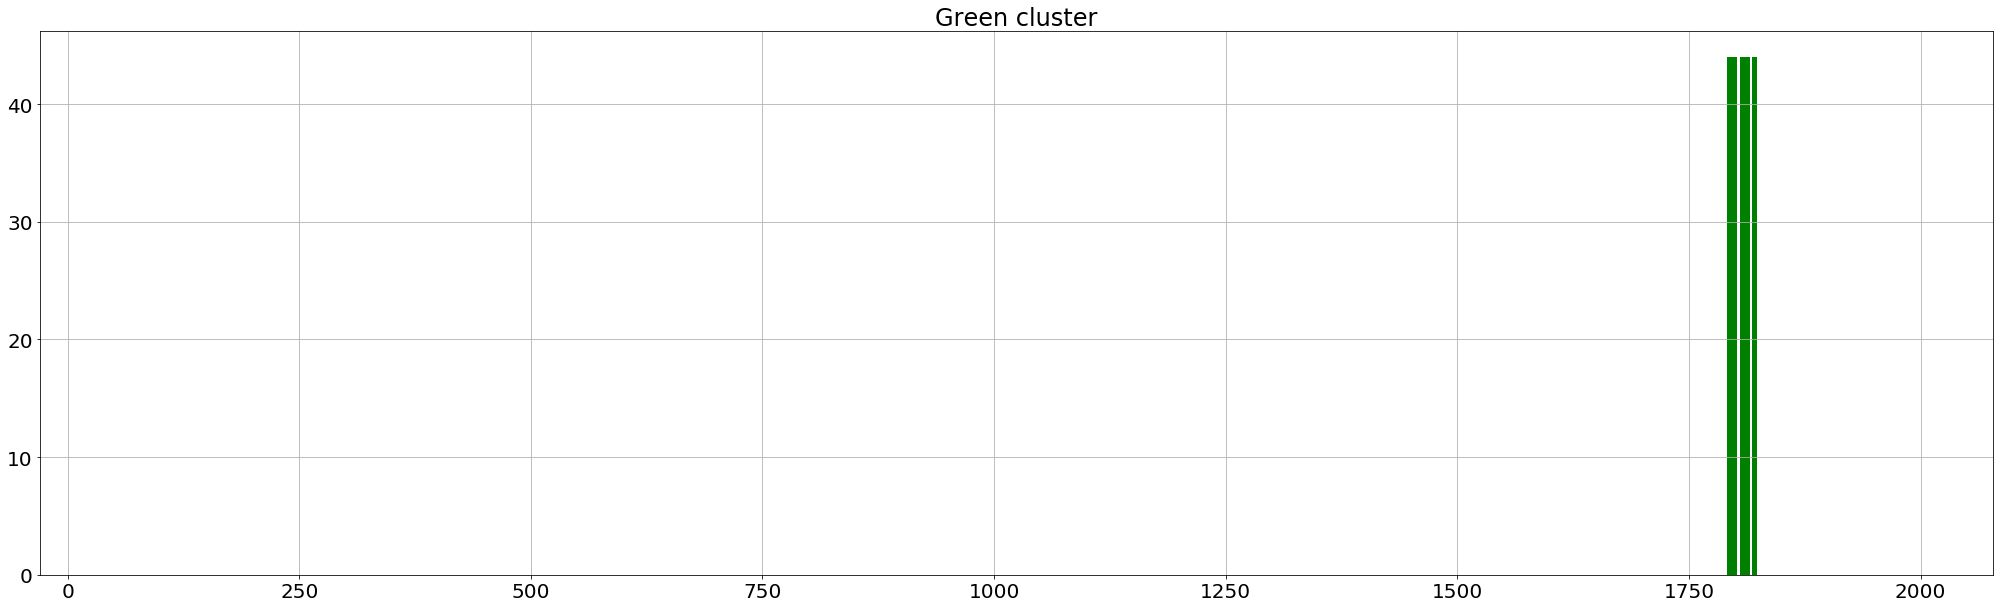

In [10]:
barData = pd.DataFrame.from_records(snG)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Green cluster')  
ax.bar(barData[0], barData[1], color='g')
ax.set_xlim([-30, 2078])
ax.grid()

plt.show()

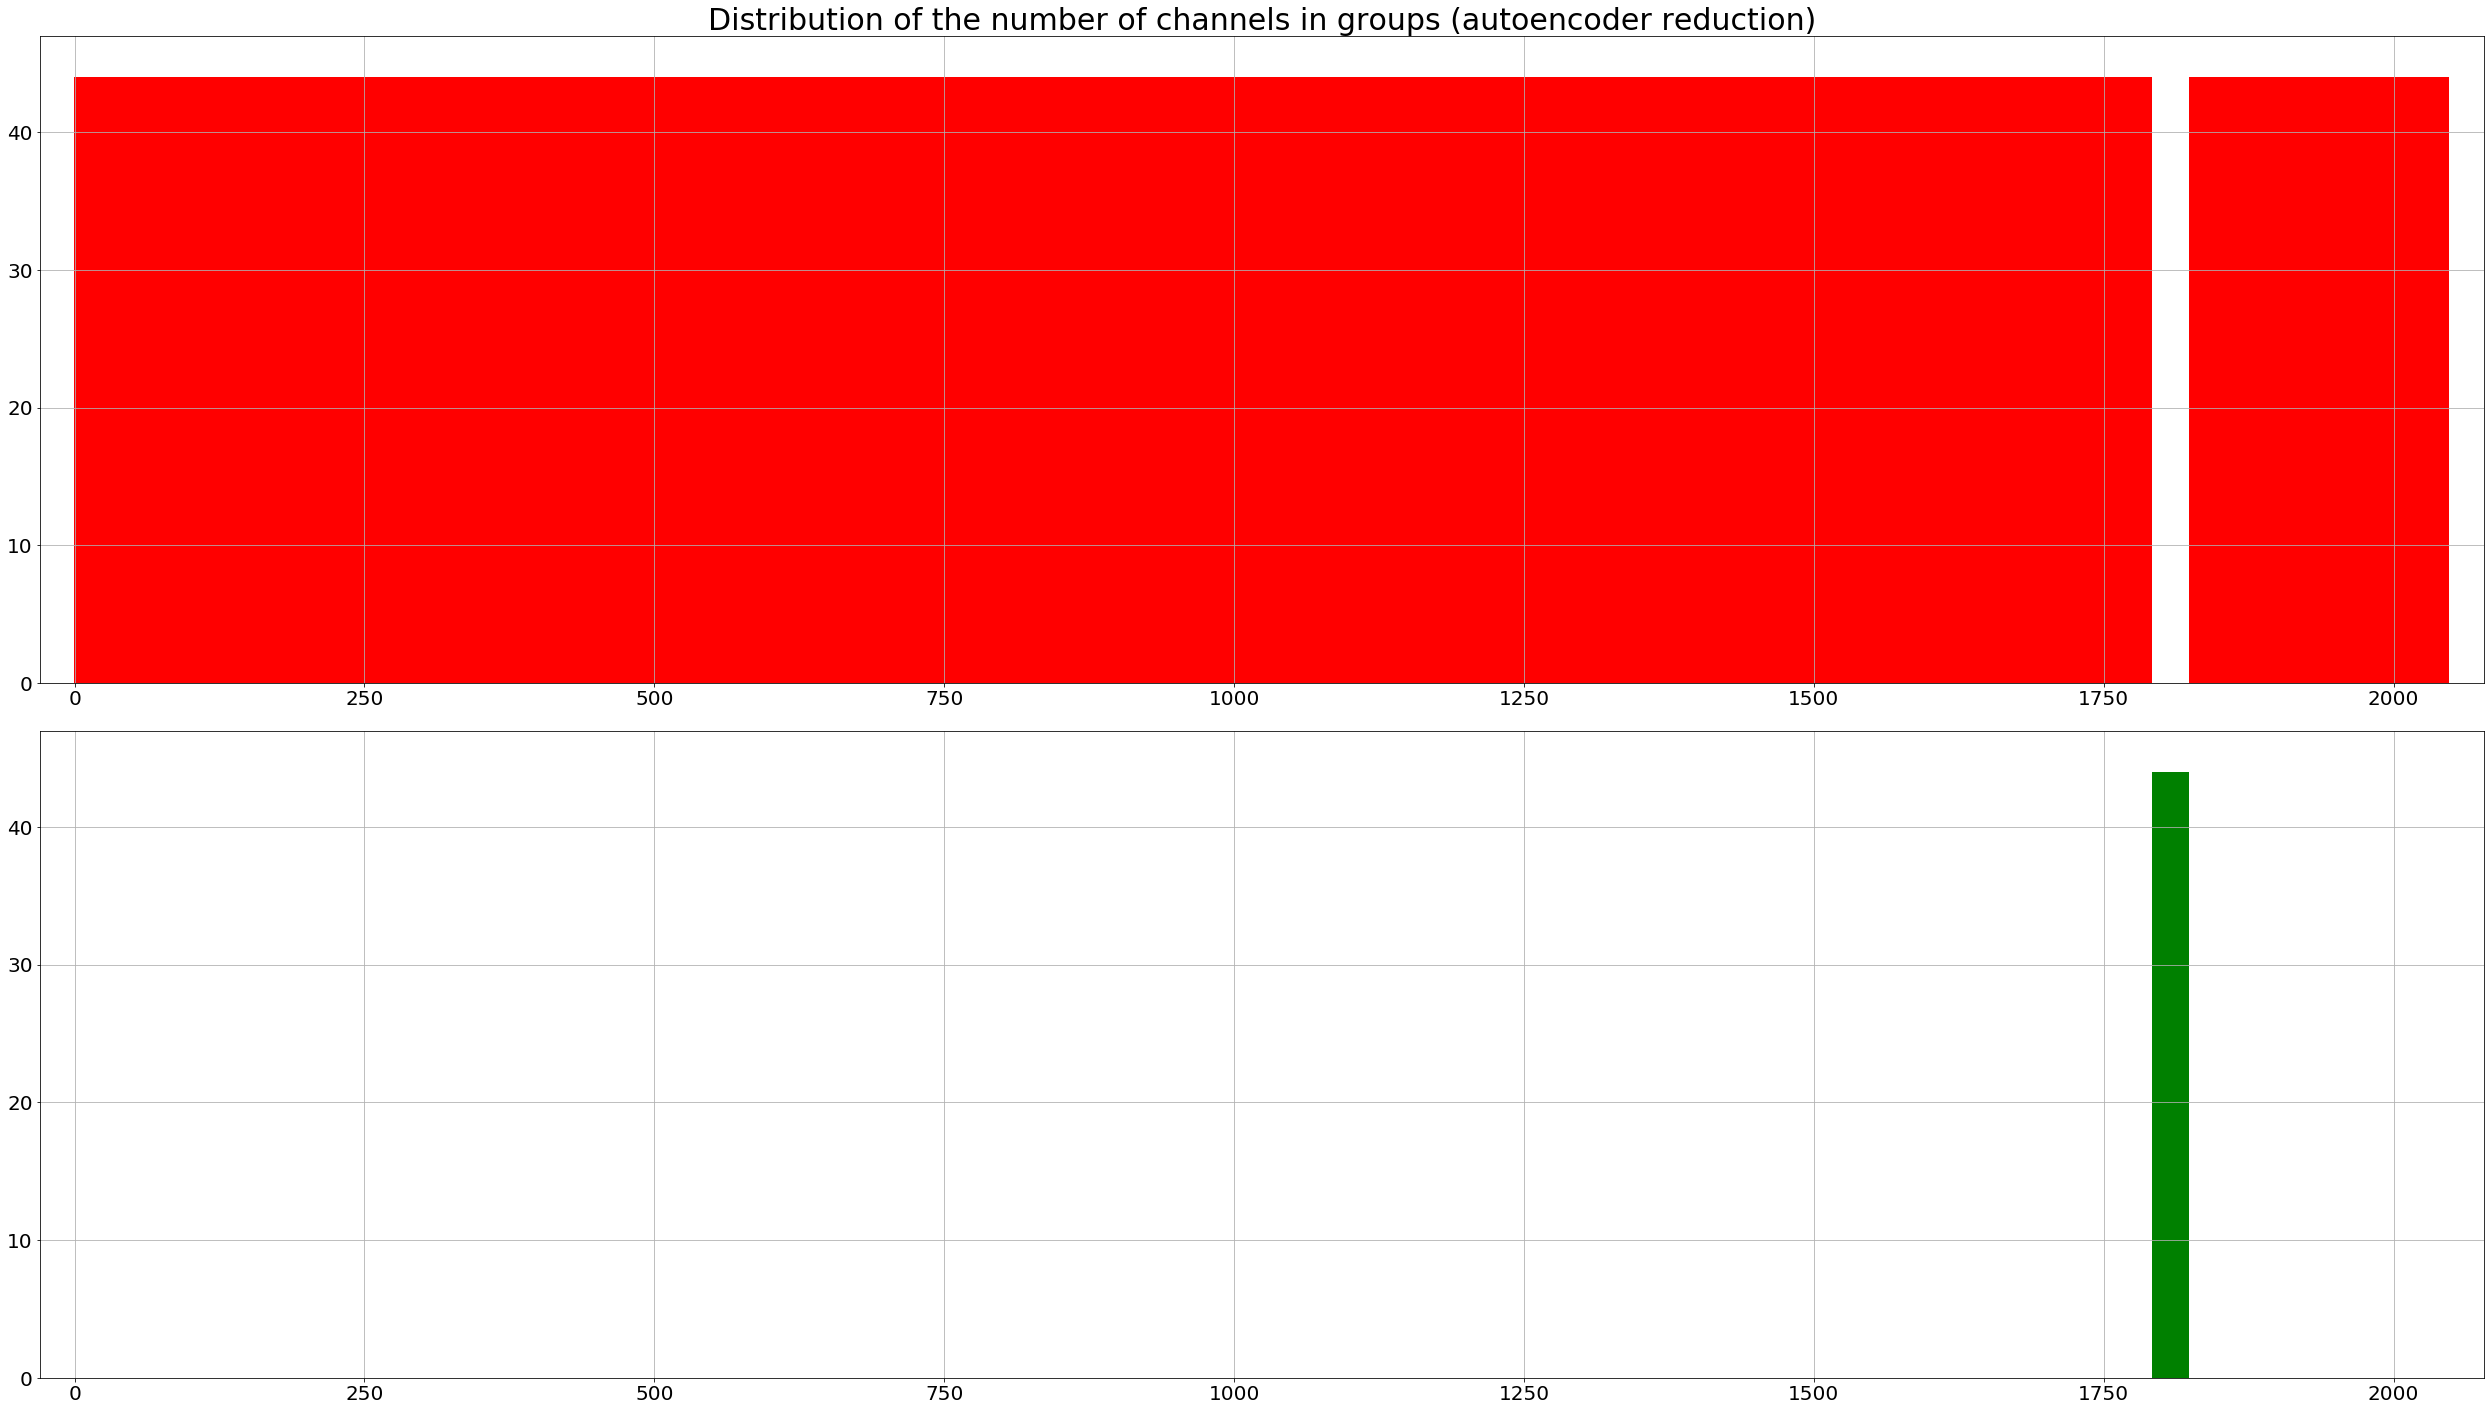

In [11]:
barDataR = pd.DataFrame.from_records(snR)
barDataG = pd.DataFrame.from_records(snG)

plt.rcParams['figure.figsize'] = [35,20]

plt.subplot(211)
plt.title("Distribution of the number of channels in groups (autoencoder reduction)", fontsize=30)
plt.bar(barDataR[0], barDataR[1], color='r', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.subplot(212)
plt.bar(barDataG[0], barDataG[1], color='g', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.tight_layout()
plt.savefig('pictures/pedestals_groups_amount_all_modules_autoencoder.png')
plt.show()

In [ ]:
chanell_encoder.save('relu_channel_model2.h5')

c:\program files\python37\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


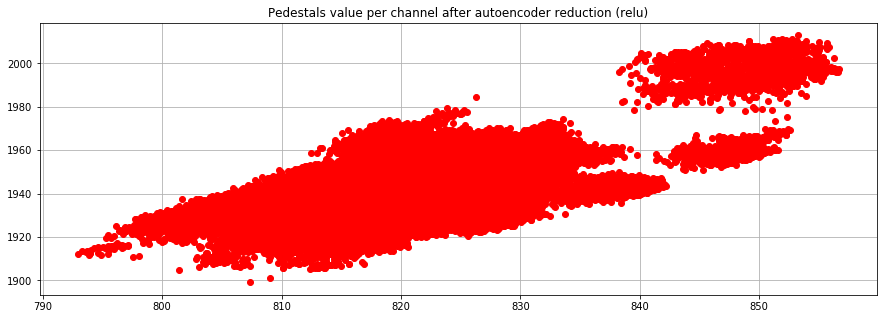

In [9]:
chanell_encoderS = load_model('relu_channel_model.h5')

fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu)')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [10]:
ncol   = 84
inputS = (ncol,)
modelSigmoid  = Sequential()

# Encoder Layers
modelSigmoid.add(Dense(40, activation = 'sigmoid', input_shape=inputS))
modelSigmoid.add(Dense(10, activation = 'sigmoid'))
modelSigmoid.add(Dense(2,  activation = 'linear', name="bottleneck"))

# Decoder Layers
modelSigmoid.add(Dense(10, activation = 'sigmoid'))
modelSigmoid.add(Dense(40, activation = 'sigmoid'))
modelSigmoid.add(Dense(84, activation = 'sigmoid'))

# Compile the Model
modelSigmoid.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelSigmoid.summary()

W0701 12:27:02.703561 140174747080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 12:27:02.748458 140174747080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 12:27:02.759629 140174747080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 12:27:02.875160 140174747080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0701 12:27:02.903033 140174747080448 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_5 (Dense)              (None, 84)                3444      
Total params: 7,746
Trainable params: 7,746
Non-trainable params: 0
_________________________________________________________________


W0701 12:27:06.788085 140174747080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



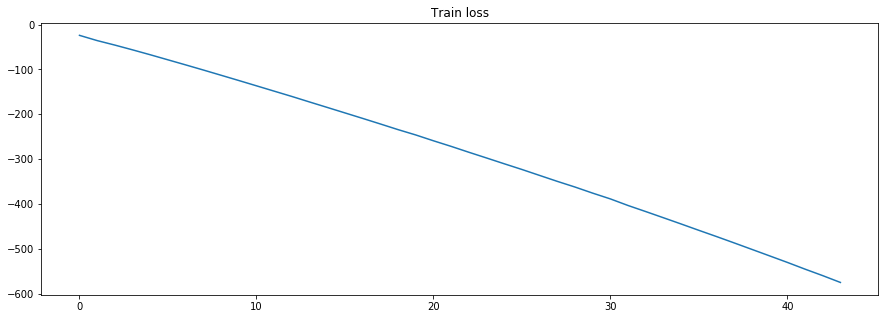

In [11]:
train_loss_fit = []
train_loss_batch = []
for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_train = data2.T
    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelSigmoid.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [12]:
chanell_encoder = Model(modelSigmoid.input, modelSigmoid.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 84)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
Total params: 3,832
Trainable params: 3,832
Non-trainable params: 0
_________________________________________________________________


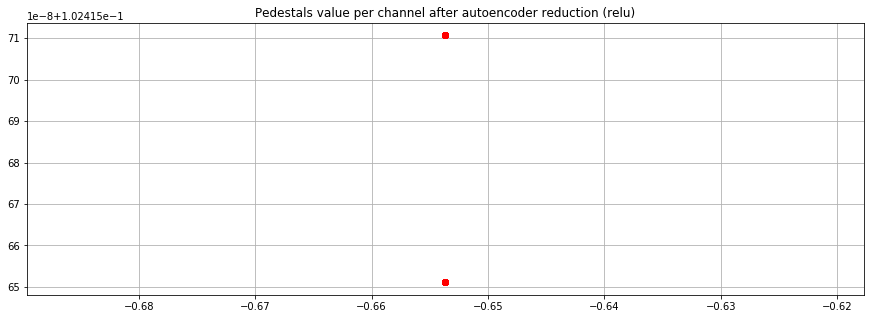

In [14]:
fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu)')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [9]:
ncol   = 84
inputS = (ncol,)
modelTanh  = Sequential()

# Encoder Layers
modelTanh.add(Dense(40, activation = 'tanh', input_shape=inputS))
modelTanh.add(Dense(10, activation = 'tanh'))
modelTanh.add(Dense(2,  activation = 'linear', name="bottleneck"))

# Decoder Layers
modelTanh.add(Dense(10, activation = 'tanh'))
modelTanh.add(Dense(40, activation = 'tanh'))
modelTanh.add(Dense(84, activation = 'sigmoid'))

# Compile the Model
modelTanh.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelTanh.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_9 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_10 (Dense)             (None, 84)                3444      
Total params: 7,746
Trainable params: 7,746
Non-trainable params: 0
_________________________________________________________________


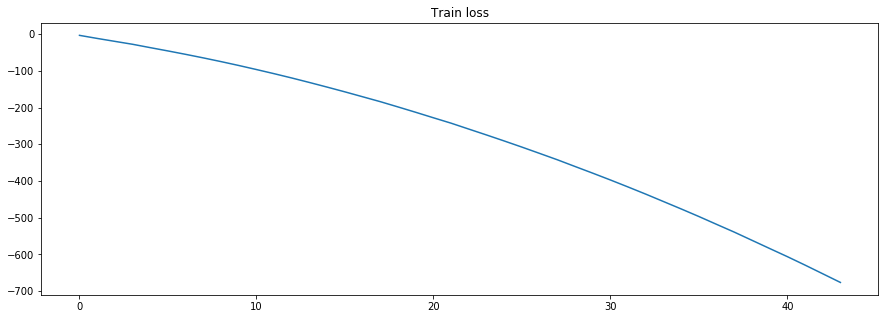

In [10]:
train_loss_fit = []
train_loss_batch = []
for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_train = data2.T
    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelTanh.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [11]:
chanell_encoder = Model(modelTanh.input, modelTanh.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6_input (InputLayer)   (None, 84)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
Total params: 3,832
Trainable params: 3,832
Non-trainable params: 0
_________________________________________________________________


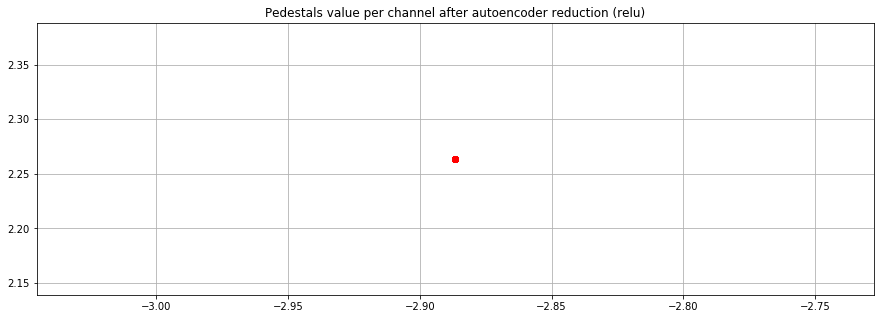

In [12]:
fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu)')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [6]:
ncol   = 42
inputS = (ncol,)
modelReluR  = Sequential()

# Encoder Layers
modelReluR.add(Dense(20, activation = 'relu', input_shape=inputS))
modelReluR.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelReluR.add(Dense(20, activation = 'relu'))
modelReluR.add(Dense(42, activation = 'sigmoid'))

# Compile the Model
modelReluR.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelReluR.summary()

W0701 23:25:19.253504  2868 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 23:25:19.284482  2868 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 23:25:19.289479  2868 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 23:25:19.399410  2868 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0701 23:25:19.408406  2868 deprecation_wrapper.py:119] From c:\program file

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 42)                882       
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


W0701 23:25:21.360897  2868 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



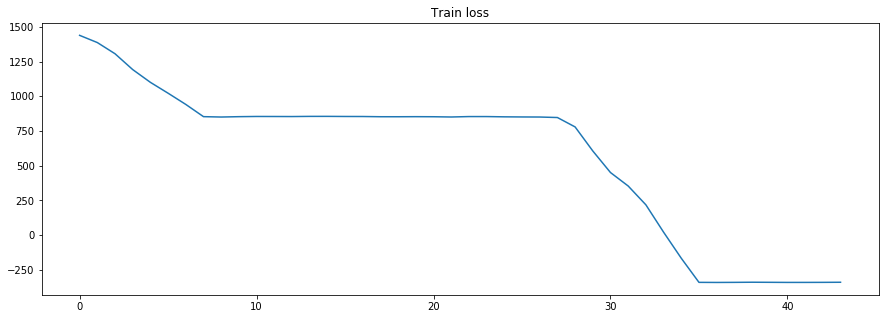

In [7]:
train_loss_batch = []
for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_train = data2.T
    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelReluR.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [15]:
chanell_encoder = Model(modelReluR.input, modelReluR.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________


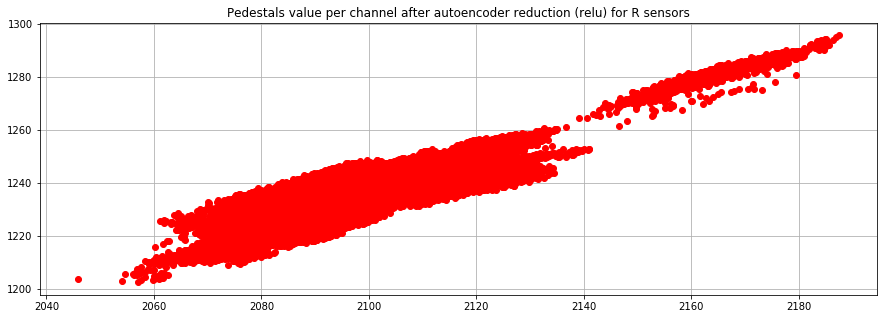

In [16]:
fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu) for R sensors')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [17]:
chanell_encoder.save('relu_R_channel_model.h5')

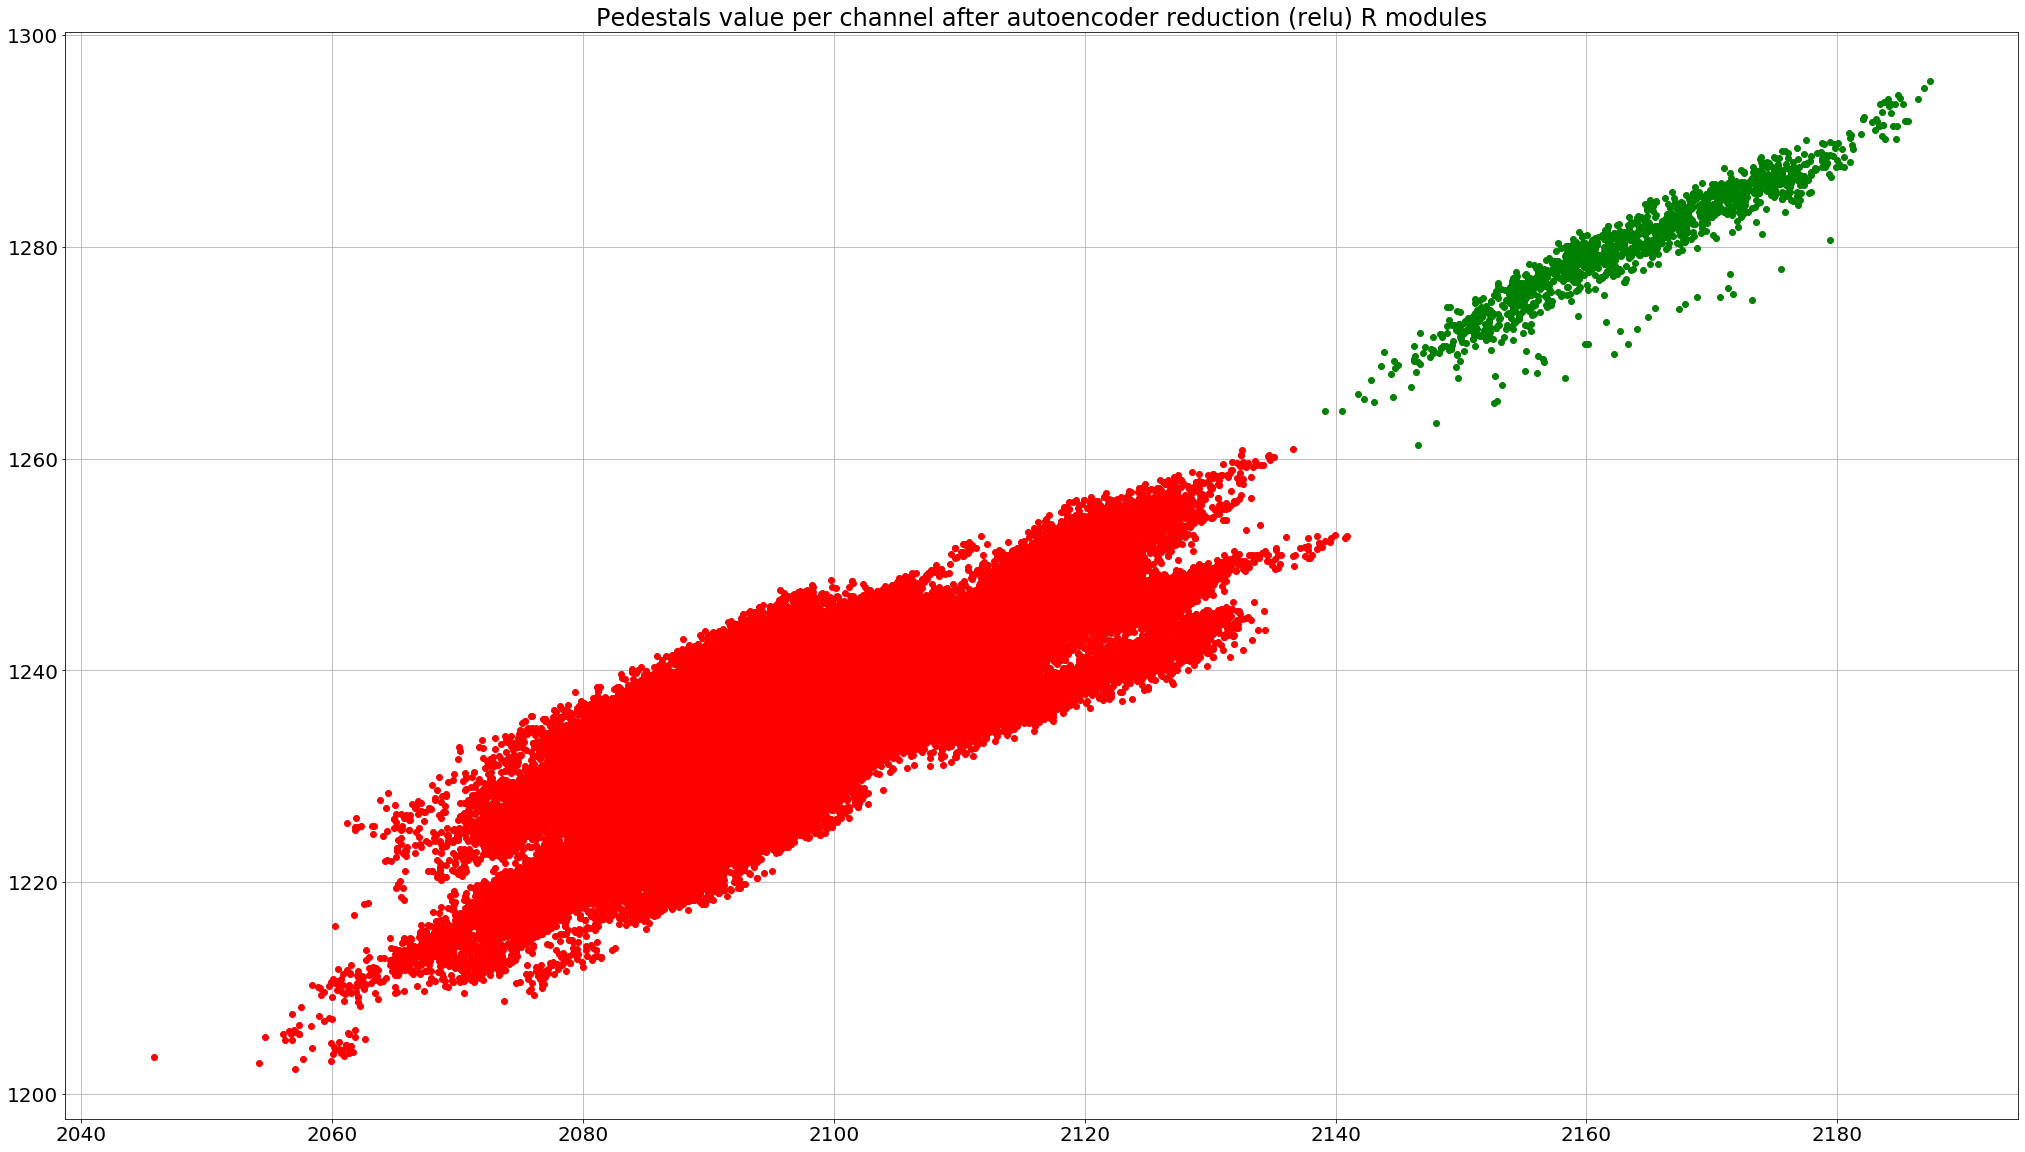

In [12]:
chanell_encoderS = load_model('relu_R_channel_model.h5')

fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu) R modules')

sensor_numbers_Gg = []
sensor_numbers_Rr = []

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    for i in data_test.index:
        if (Zenc[i,0] > 2138) and (Zenc[i,1] > 1260):
            ax.plot(Zenc[i,0], Zenc[i,1], 'go')
            sensor_numbers_Gg.append(i)
        else:
            ax.plot(Zenc[i,0], Zenc[i,1], 'ro')
            sensor_numbers_Rr.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [13]:
print("[channel number, amount]")
for x in set(sensor_numbers_Gg):
    print("[{:>14}, {:>6}]".format(x, sensor_numbers_Gg.count(x)))

[channel number, amount]
[          1792,     44]
[          1793,     44]
[          1794,     44]
[          1795,     44]
[          1796,     44]
[          1797,     44]
[          1798,     44]
[          1799,     44]
[          1800,     44]
[          1801,     44]
[          1802,     44]
[          1803,     44]
[          1804,     44]
[          1805,     44]
[          1806,     44]
[          1807,     44]
[          1808,     44]
[          1809,     44]
[          1810,     44]
[          1811,     44]
[          1812,     44]
[          1813,     44]
[          1814,     44]
[          1815,     44]
[          1816,     44]
[          1817,     44]
[          1818,     44]
[          1819,     44]
[          1820,     44]
[          1821,     44]
[          1822,     44]
[          1823,     44]
[           448,      1]


In [14]:
snR = [[x,sensor_numbers_Rr.count(x)] for x in set(sensor_numbers_Rr)]
snG = [[x,sensor_numbers_Gg.count(x)] for x in set(sensor_numbers_Gg)]

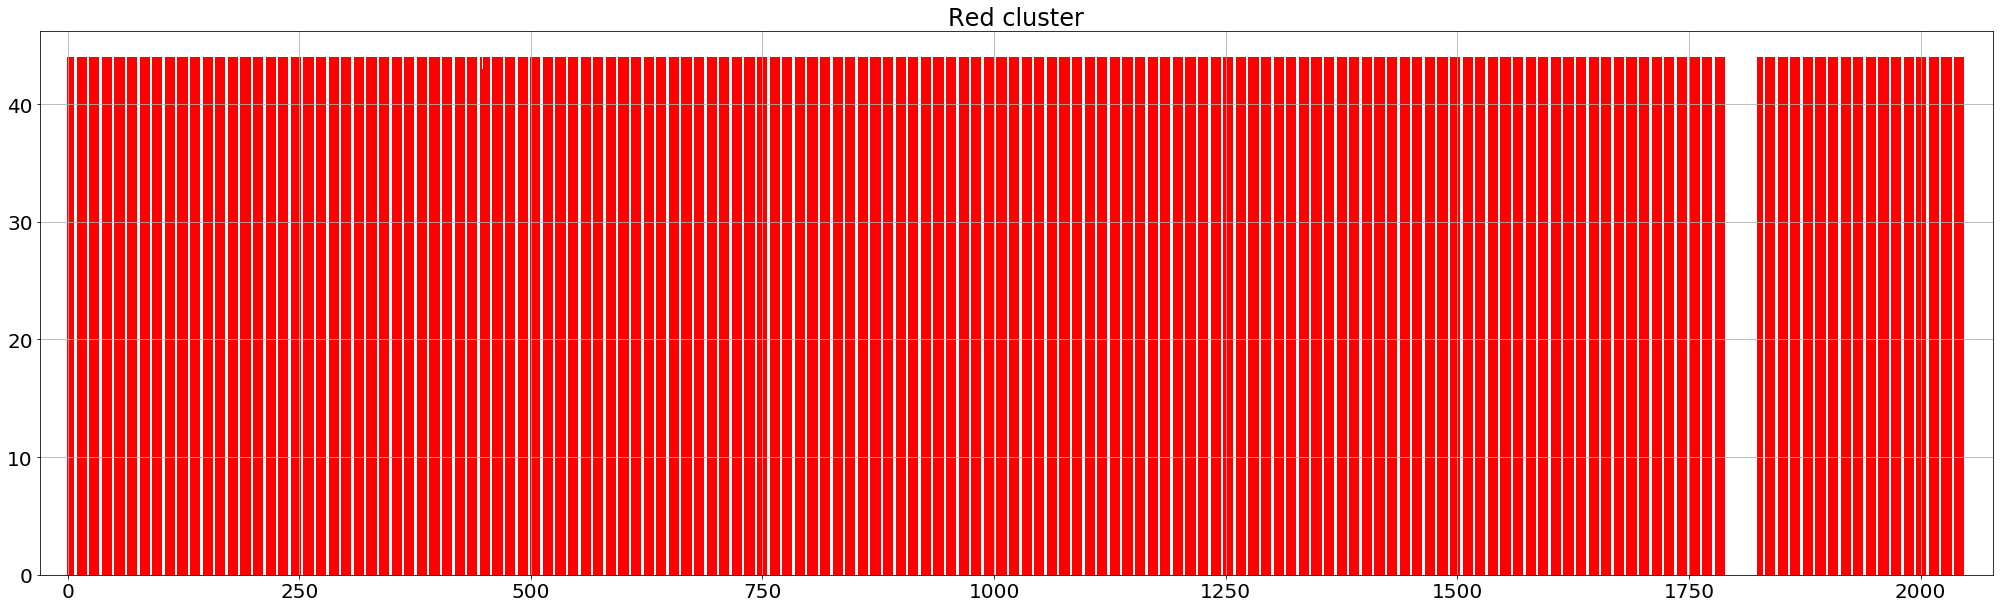

In [15]:
barData = pd.DataFrame.from_records(snR)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Red cluster')  
ax.bar(barData[0], barData[1], color='r')
ax.set_xlim([-30, 2078])
ax.grid()

plt.show()

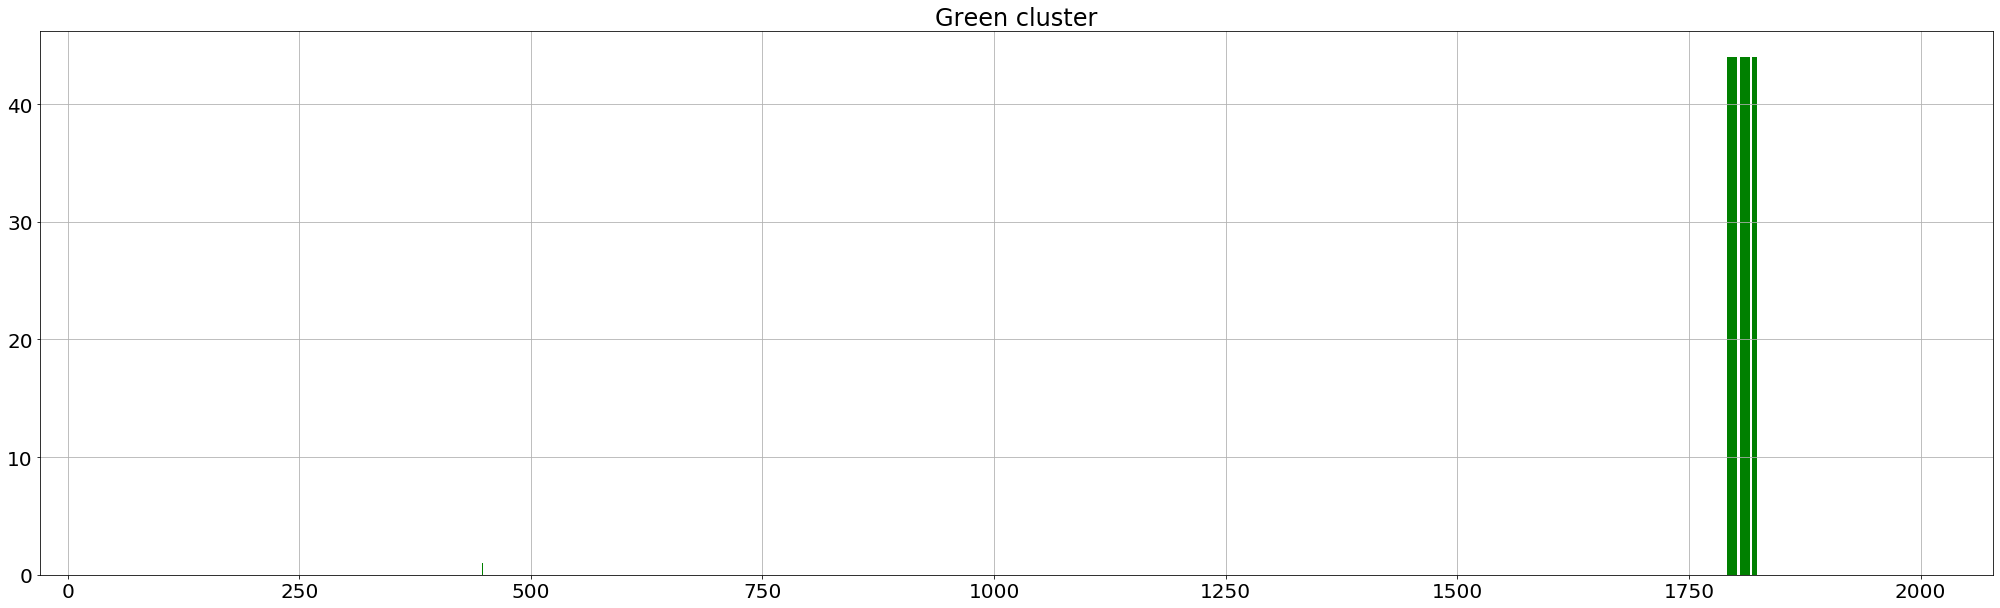

In [16]:
barData = pd.DataFrame.from_records(snG)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Green cluster')  
ax.bar(barData[0], barData[1], color='g')
ax.set_xlim([-30, 2078])
ax.grid()

plt.show()

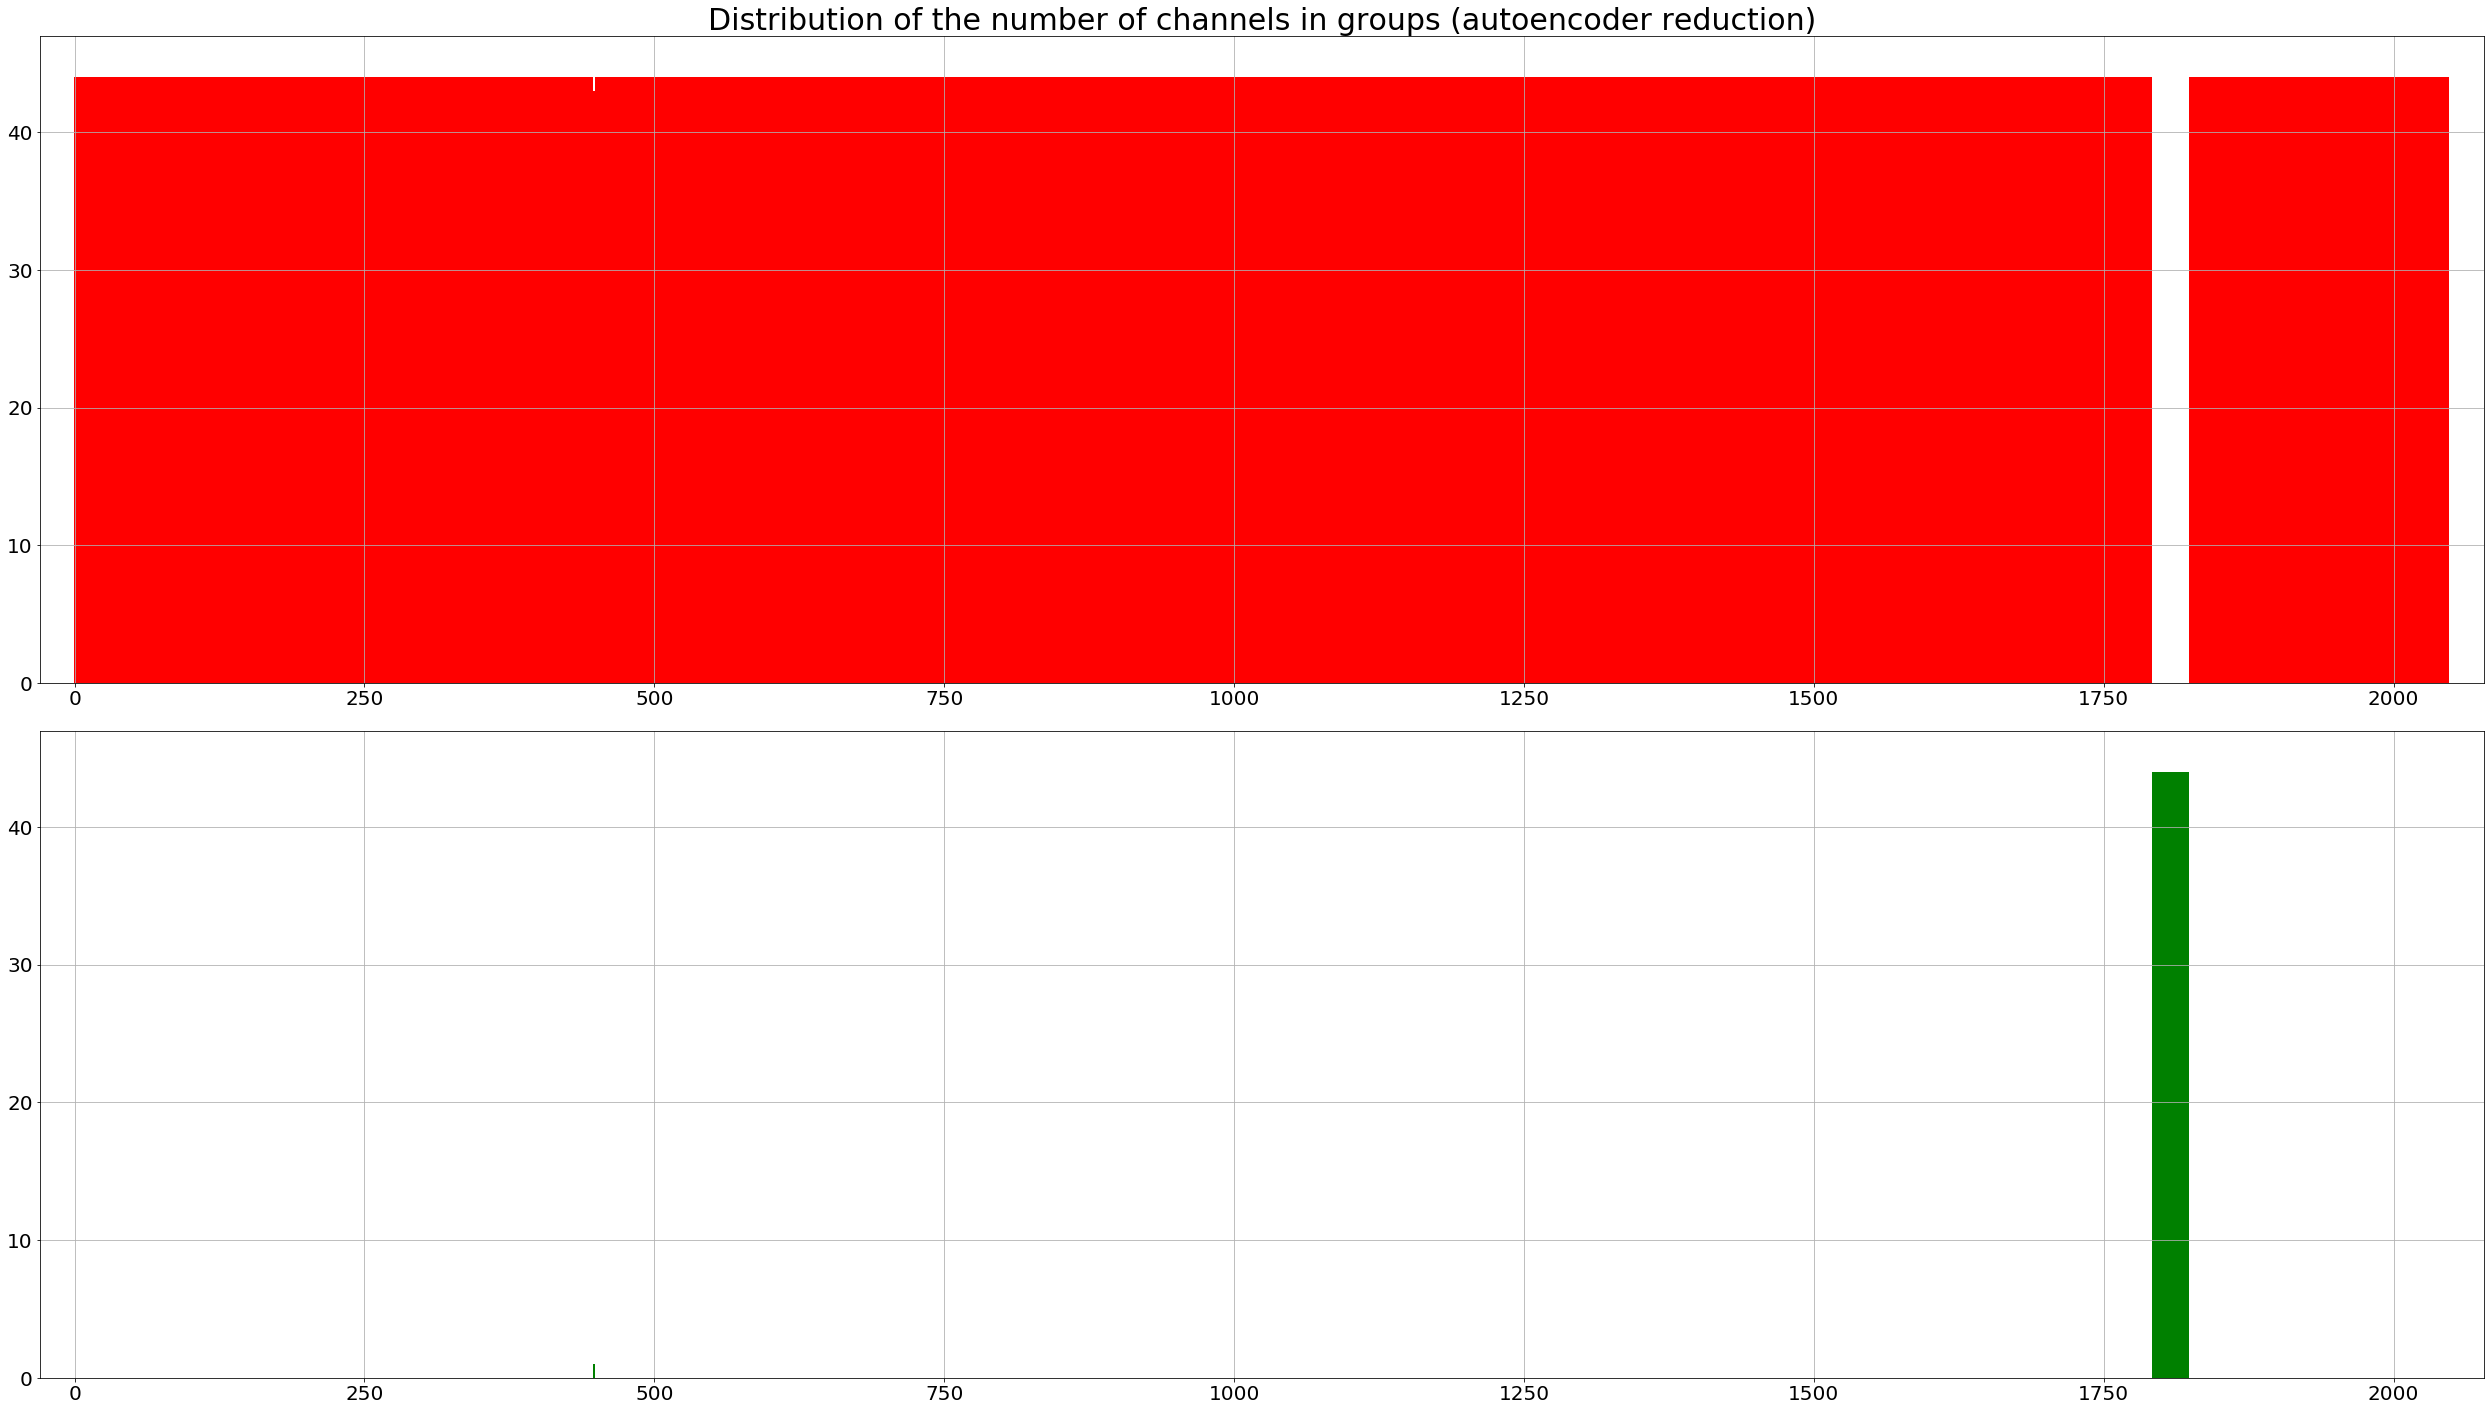

In [17]:
barDataR = pd.DataFrame.from_records(snR)
barDataG = pd.DataFrame.from_records(snG)

plt.rcParams['figure.figsize'] = [35,20]

plt.subplot(211)
plt.title("Distribution of the number of channels in groups (autoencoder reduction)", fontsize=30)
plt.bar(barDataR[0], barDataR[1], color='r', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.subplot(212)
plt.bar(barDataG[0], barDataG[1], color='g', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.tight_layout()
plt.savefig('pictures/pedestals_groups_amount_R_modules_autoencoder.png')
plt.show()

In [66]:
ncol   = 42
inputS = (ncol,)
modelReluPhi = Sequential()

# Encoder Layers
modelReluPhi.add(Dense(20, activation = 'relu', input_shape=inputS))
modelReluPhi.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelReluPhi.add(Dense(20, activation = 'relu'))
modelReluPhi.add(Dense(42, activation = 'sigmoid'))

# Compile the Model
modelReluPhi.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelReluPhi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
_________________________________________________________________
dense_38 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_39 (Dense)             (None, 42)                882       
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


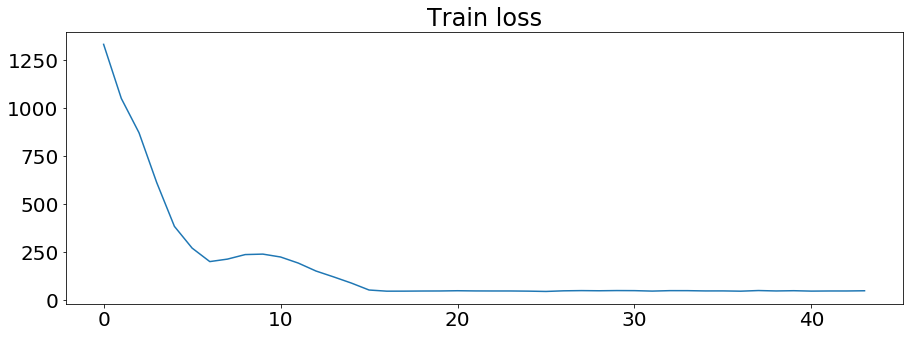

In [67]:
train_loss_batch = []

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(phi_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_train = data2.T
    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelReluPhi.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [68]:
chanell_encoder = Model(modelReluPhi.input, modelReluPhi.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37_input (InputLayer)  (None, 42)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________


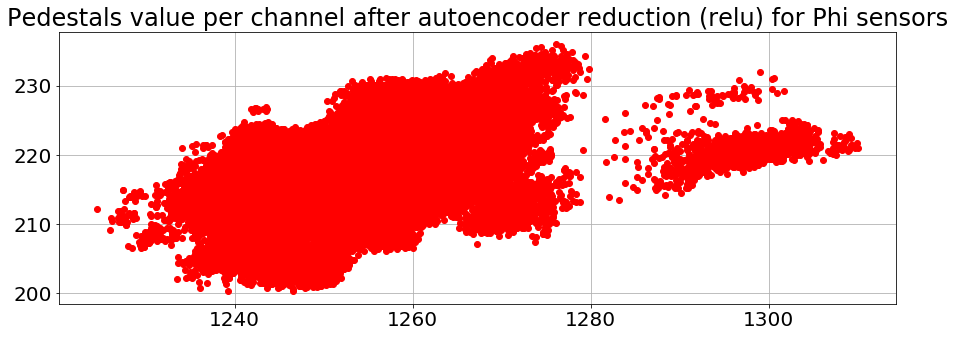

In [69]:
fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu) for Phi sensors')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(phi_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [70]:
chanell_encoder.save('relu_Phi_channel_model.h5')

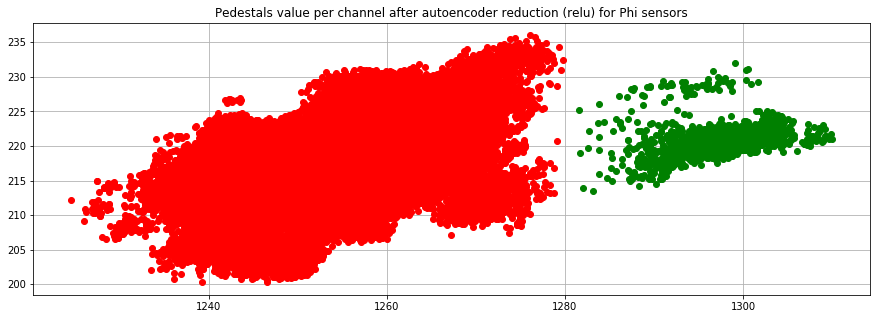

In [8]:
chanell_encoderS = load_model('relu_Phi_channel_model.h5')

sensor_numbers_RrR = []
sensor_numbers_GgG = []

fig, ax = plt.subplots()
ax.set_title('Pedestals value per channel after autoencoder reduction (relu) for Phi sensors')

for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data = data[pd.DataFrame(data[1].tolist()).isin(phi_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2049]

    data2.index = names
    data2.columns = range(2048)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    for i in data_test.index:
        if (Zenc[i,0] > 1280):
            ax.plot(Zenc[i,0], Zenc[i,1], 'go')
            sensor_numbers_GgG.append(i)
        else:
            ax.plot(Zenc[i,0], Zenc[i,1], 'ro')
            sensor_numbers_RrR.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [12]:
print("[channel number, amount]")
for x in set(sensor_numbers_GgG):
    print("[{:>14}, {:>6}]".format(x, sensor_numbers_GgG.count(x)))

[channel number, amount]
[          1792,     44]
[          1793,     44]
[          1794,     43]
[          1795,     44]
[          1796,     44]
[          1797,     44]
[          1798,     44]
[          1799,     44]
[          1800,     44]
[          1801,     44]
[          1802,     44]
[          1803,     44]
[          1804,     44]
[          1805,     44]
[          1806,     44]
[          1807,     44]
[          1808,     44]
[          1809,     44]
[          1810,     44]
[          1811,     44]
[          1812,     44]
[          1813,     44]
[          1814,     44]
[          1815,     44]
[          1816,     44]
[          1817,     44]
[          1818,     44]
[          1819,     44]
[          1820,     44]
[          1821,     44]
[          1822,     44]
[          1823,     44]
[           448,      1]


In [10]:
snR = [[x,sensor_numbers_RrR.count(x)] for x in set(sensor_numbers_RrR)]
snG = [[x,sensor_numbers_GgG.count(x)] for x in set(sensor_numbers_GgG)]

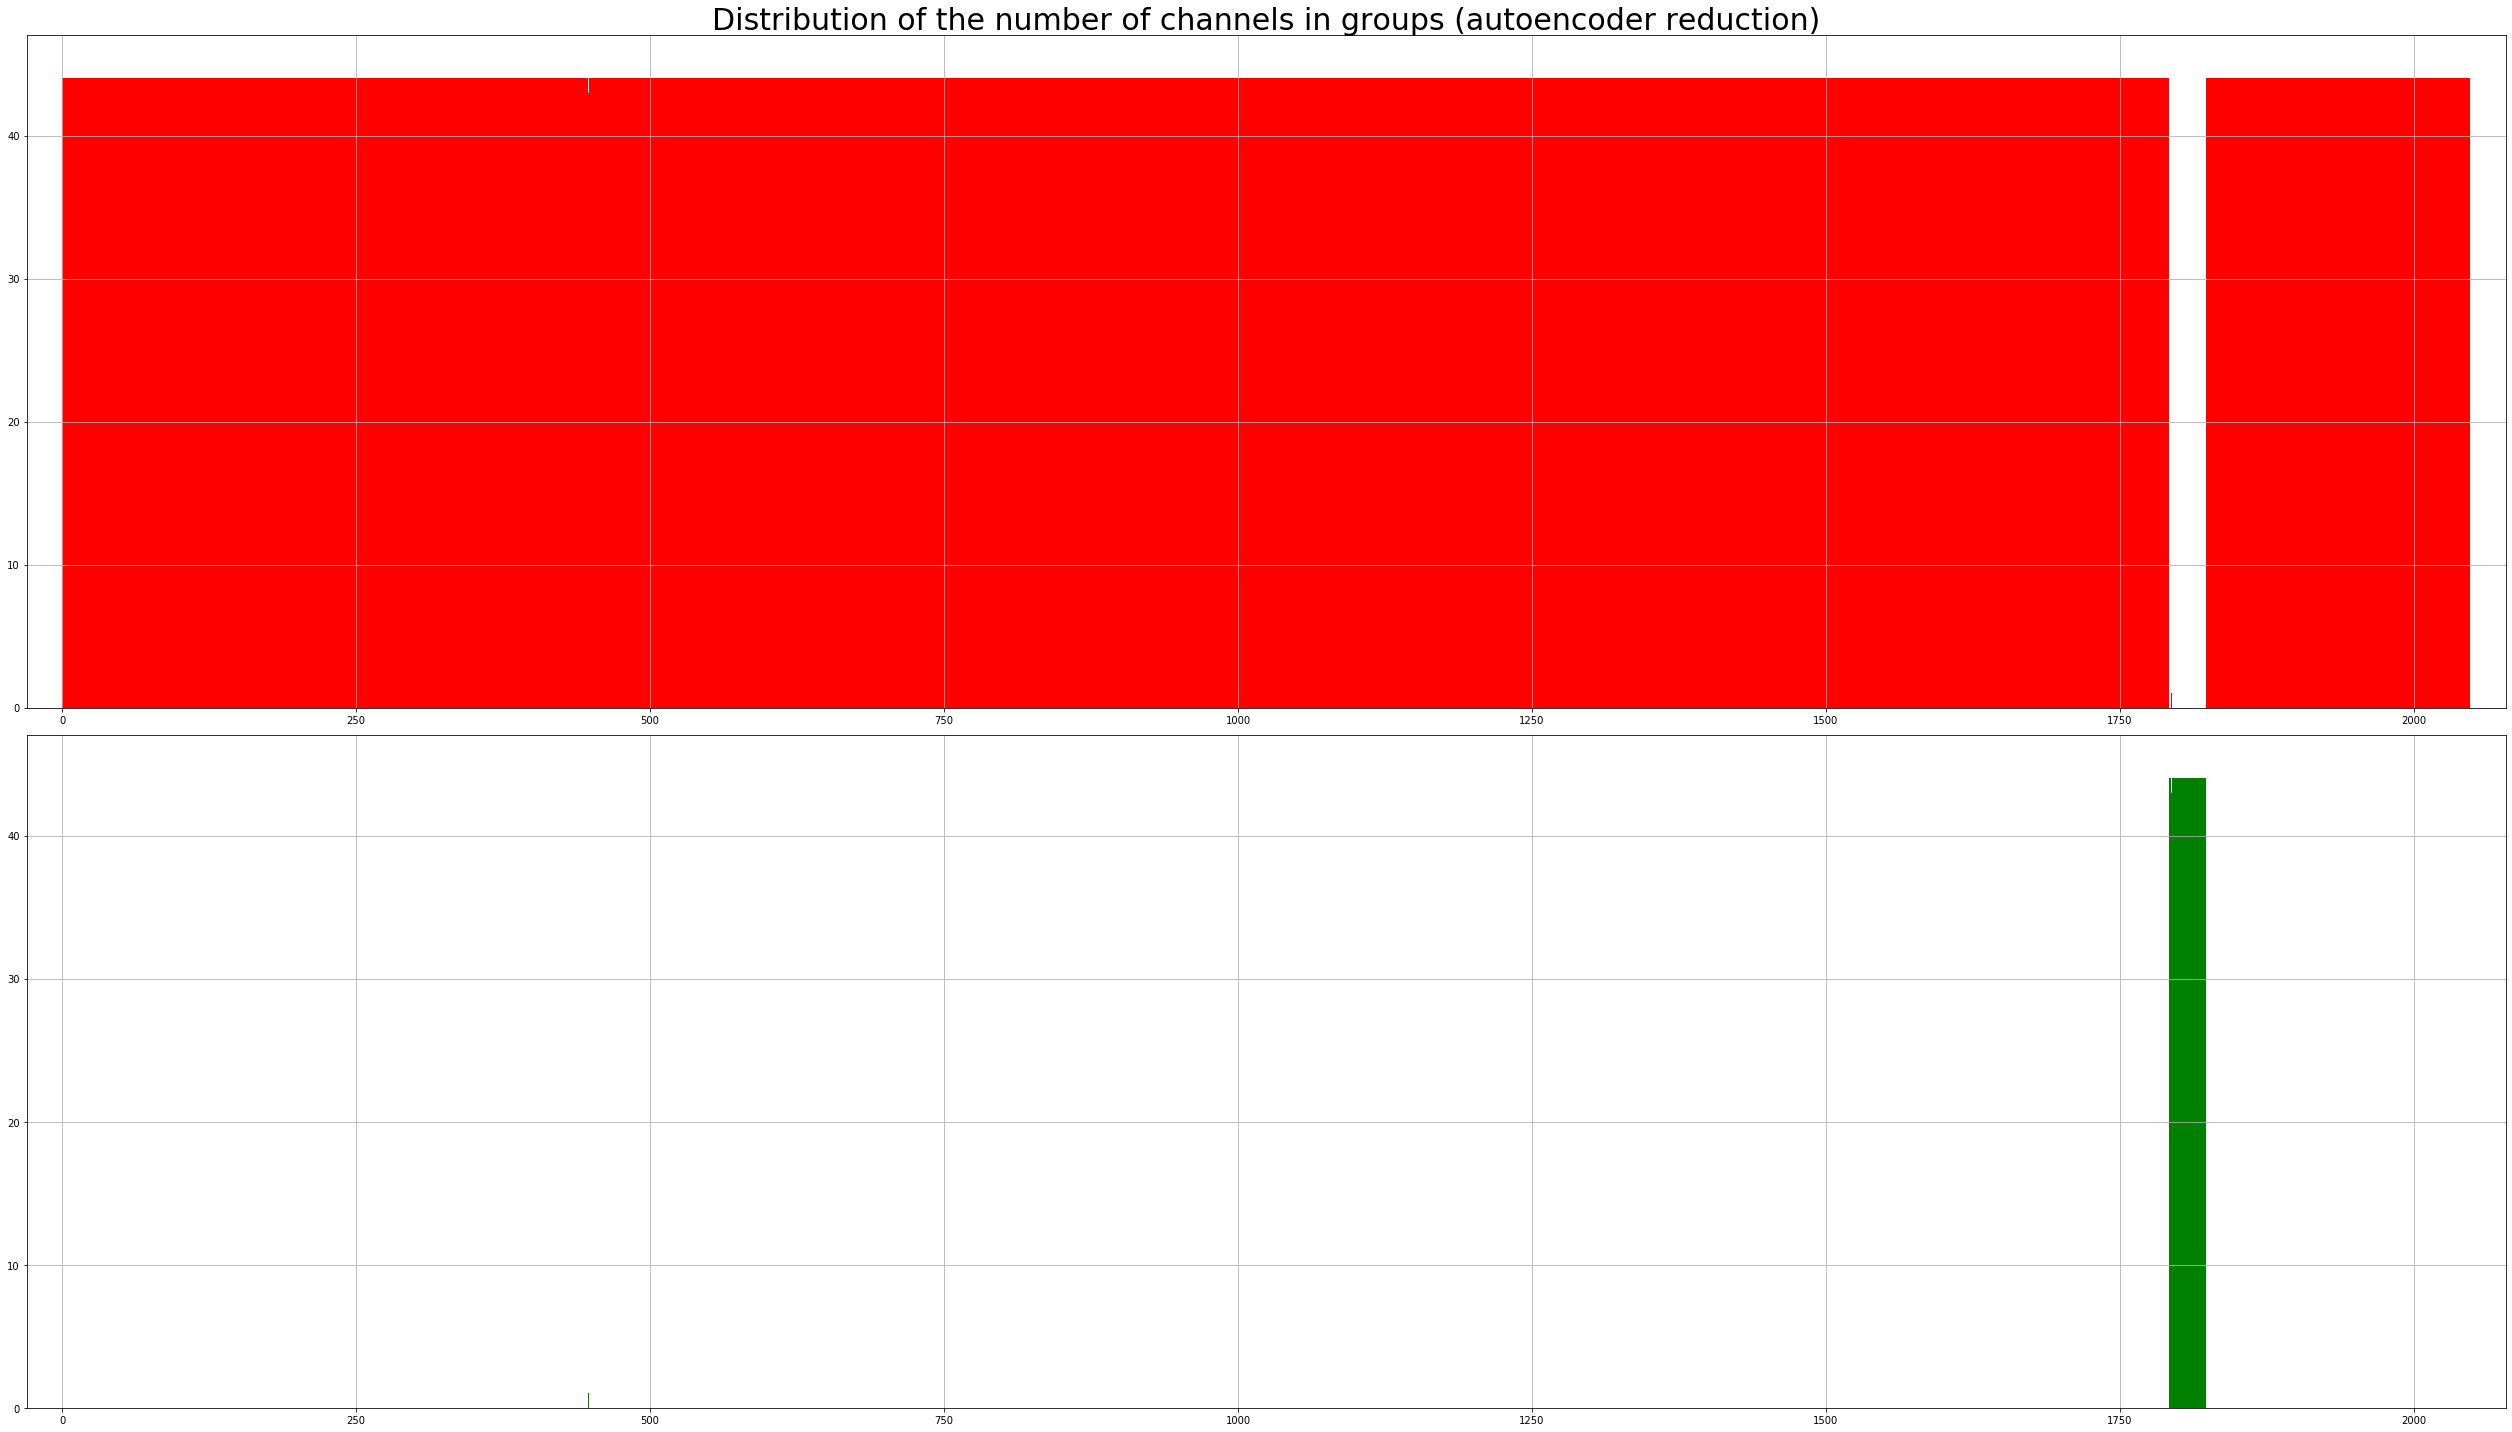

In [11]:
barDataR = pd.DataFrame.from_records(snR)
barDataG = pd.DataFrame.from_records(snG)

plt.rcParams['figure.figsize'] = [35,20]

plt.subplot(211)
plt.title("Distribution of the number of channels in groups (autoencoder reduction)", fontsize=30)
plt.bar(barDataR[0], barDataR[1], color='r', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.subplot(212)
plt.bar(barDataG[0], barDataG[1], color='g', width=1)
plt.grid(True)
plt.xlim([-30, 2078])
plt.ylim([0, 47])

plt.tight_layout()
plt.savefig('pictures/pedestals_groups_amount_R_modules_autoencoder.png')
plt.show()

In [10]:
ncol   = 84
nrow   = 2048
inputS = (nrow, ncol)
modelConvRelu  = Sequential()

# Encoder Layers
modelConvRelu.add(Conv1D(filters = 84, kernel_size = 2, activation = 'relu',    padding='same', input_shape=inputS))
modelConvRelu.add(MaxPooling1D(pool_size = 1))
modelConvRelu.add(Conv1D(filters = 40, kernel_size = 2, activation = 'relu',    padding='same'))
modelConvRelu.add(MaxPooling1D(pool_size = 1))
modelConvRelu.add(Conv1D(filters = 2,  kernel_size = 2, activation = 'relu',    padding='same', name="bottleneck"))

# Decoder Layers
modelConvRelu.add(Conv1D(filters = 2,  kernel_size = 2, activation = 'relu',    padding='same'))
modelConvRelu.add(UpSampling1D(size = 1))
modelConvRelu.add(Conv1D(filters = 40, kernel_size = 2, activation = 'relu',    padding='same'))
modelConvRelu.add(UpSampling1D(size = 1))
modelConvRelu.add(Conv1D(filters = 84, kernel_size = 2, activation = 'sigmoid', padding='same'))

# Compile the Model
modelConvRelu.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelConvRelu.summary()

W0702 09:54:19.506051 11360 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2048, 84)          14196     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2048, 84)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2048, 40)          6760      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2048, 40)          0         
_________________________________________________________________
bottleneck (Conv1D)          (None, 2048, 2)           162       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 2)           10        
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 2048, 2)           0         
__________

In [29]:
train_loss_batch = []
for file in data_files:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("pedestal")]
    data2 = data.loc[:, 2:2049]

    data2.index = module_names()
    data2.columns = range(2048)

    data_train = data2.T
    data_train = np.expand_dims(data_train, axis=2)    
    #history = modelRelu.fit(data_train, data_train, batch_size=128, epochs=10, verbose=0)
    #train_loss_fit.append(history.history['loss'])
    history = modelConvRelu.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

ValueError: Error when checking input: expected conv1d_39_input to have shape (2048, 84) but got array with shape (84, 1)